# Kinetic Theory of Ideal Gases



### Peter Onyisi
<img src="images/texas_logo.png" width="400" align="left"/>

We'll use the "ideal gas" to illustrate how statistical methods apply to realistic physical systems, and to introduce the hypotheses of statistical mechanics.

The ideal gas is a simplified model of real gases. In an ideal gas, the molecules are small relative to the total volume they move around in, and experience no interactions between each other except for random _elastic_ collisions. (Real gases have forces between the molecules/atoms, which if you cool them enough cause the gases to liquefy.) So basically we treat the molecules as absolutely hard balls that don't rotate.  The molecules also undergo elastic collisions with the walls of the container they are put in; this causes a force on the wall and is responsible for the _pressure_ of the gas.

Ideal gases follow the famous relationship $PV = nRT$, where
* $P$ is the pressure of the gas,
* $V$ is the volume of the gas container,
* $n$ is the number of molecules in moles,
* $R$ is the _ideal gas constant_ 8.314 J/K &middot; mol, whose origin we will soon explain
* $T$ is the temperature in an "absolute" scale, usually Kelvin. This is related to the total energy of the gas in a way we will discuss

For an ideal gas, all "macroscopic" properties are determined by $P$, $V$, and $T$. Microscopically the states of the system are determined by the positions and velocities (or momenta) of all the molecules.

Statistical mechanics hopes to reason from probability arguments to explain why systems with a lot of particles have the behaviors they do. In order to do this a number of arguments are typically made.
* the *principle of indifference*: if we have a set of possible states for a system to be in, but no further information, we should assume equal probabilities for all of them (but we have to be careful about the counting!),
* the *ergodic hypothesis*: consider all conceivable states a system could be in which are consistent with the bulk properties we know about it - e.g., for an ideal gas, a collection of $N$ particles inside a volume $V$ with a total energy $E$. Obviously at any given time the system should be only in one state, but it will evolve in time. The ergodic hypothesis says that _eventually_ the system will visit "every possible state". Because of this, if we just come upon a system, we can ignore the initial way the system was prepared and assume that the system is in some random state consistent with the bulk properties.  The average behavior in time will be the same as the average behavior over the ensemble of possible states.
* *statistical equilibrium*: we don't happen to be measuring the system in an extremely unlikely state (e.g. all the molecules of a gas being in one half of a container). It is much easier to describe equilibrium systems in terms of a few macroscopic parameters, because the fluctuations in those parameters are small. (An equilibrium ideal gas has one pressure, while a non-equilibrium ideal gas may have a pressure that depends strongly on position.)

These hypotheses have to be treated with some care:
* For a continuous variable like position or velocity, how does one count the states for the principle of indifference? Should we make equal boxes in the variables? Should we choose equal boxes in velocity, momentum, energy? (They will give different answers - momentum vs velocity will depend on the mass, and since energy is a nonlinear function of velocity, equal spacing in energy is not the same as equal spacing in momentum.) For this problem, where each particle has a position and a momentum which are both continuous variables, the correct answer is to use equal intervals in the position and momentum of the particles (so-called *phase space*).
* For the ergodic hypothesis, one could easily imagine a situation (e.g. a wall of non-interacting molecules with parallel velocities bouncing back and forth in a box) that would not visit all possible states. In most realistic situations these are profoundly unlikely but theoretically possible. More common is a situation where visiting all possible states is theoretically possible but would take essentially infinite time (e.g., significant distortions in a crystal lattice) or constrained by other conservation laws (e.g. a perfect top will always have its axis point in the same direction, due to conservation of angular momentum). In those cases we need to consider the set of _actually_ accessible states.
* There are many non-equilibrium systems in the real world. For example, immediately after a balloon is burst, the gas inside is in a very non-equilibrium situation: the pressure of the gas is much higher than that of the outside air, so the gas tends to expand outward rapidly.  Eventually the pressures will become equal and the balloon gas will mix with the outside air, at which point equilibrium will be restored; we generally assume that a system will eventually reach equilibrium. For a system which is being forced (e.g. a car engine) this may never happen, however.

Our "hard sphere" model of the ideal gas is actually mathematically proven to be ergodic, so no problems here.  The bouncing of hard spheres depends very strongly on the precise angle at which they collide, so a few collisions is in general enough to randomize all the velocities. For a general problem, usually one has to consider the specific details to consider what the set of possible accessible states is.

The model works the following way:
* start with $N$ particles, with specified positions and velocities.
* use the velocities to extrapolate forward by a time $\Delta T$.
* if the particles have hit the wall, reverse their velocity component perpendicular to the wall.
* if the particles are closer to each other than the sum of their radii, bounce them off each other (reverse the velocity component parallel to the line connecting the centers of the particles).
* repeat.

We can set up the model with various possibilities for the initial positions and velocities and see what happens. We can look at various parameters such as the fraction of particles in one half of the box, or the pressure on a wall. We'll do a 2D model as those are easier to mentally visualize, but it could be easily done in 3D also.

You might wonder what the units are here. For now let's assume everything is specified in SI units. One complication is that in 2D a pressure is a force per unit _length_ (the size of the side of the box) rather than per unit _area_.

The energy of the gas in this model is the total kinetic energy of the molecules. What should one set it to? (This is basically the question of what the distribution of velocities of the molecules should be.) Eventually we will connect this to the temperature of the molecules, but for now we just choose a value.

This model was first discussed by James Clerk Maxwell (yes, same Maxwell as of Maxwell's equations!).

In [11]:
# TACC: install if necessary
! pip3 install --user numba
INSTALL_PATH='/home/jupyter/mydata/jupyter_packages/lib/python3.6/site-packages'
import sys, os
if os.access(INSTALL_PATH, os.R_OK) and INSTALL_PATH not in sys.path:
    sys.path.insert(0, INSTALL_PATH)

In [12]:
# import Python packages
import numpy
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['animation.embed_limit'] = 50
import math
import tqdm.notebook
from IPython.display import HTML
from matplotlib import animation
import numba

In [13]:
SCALING=1
NPARTICLES=int(1000*SCALING)
NDIMS=2 # 2 dimensions
SIZE=numpy.array([10,10]) # size of box
DELTAT=0.1
TEMPSCALE=1
masses = numpy.array([1.*(1/SCALING)]*(NPARTICLES))
radii = numpy.array([0.05*(1/SCALING**(1/NDIMS))]*(NPARTICLES))

# Initial conditions
# initialize randomly across entire box
positions = (numpy.random.uniform(-0.5, 0.5, size=(NPARTICLES,NDIMS)))*SIZE
# initialize randomly across left half of box
#positions = (numpy.random.uniform(-0.5, 0., size=(NPARTICLES,NDIMS)))*SIZE

# initialize velocities randomly in both directions (std. dev. magnitude sqrt(NDIMS)*sqrt(TEMP))
velocities = (numpy.random.normal(0, 1, size=(NPARTICLES,NDIMS)))*math.sqrt(TEMPSCALE)
# all particles moving along x with velocity sqrt(NDIMS)
#velocities = numpy.array([[math.sqrt(NDIMS),0]]*NPARTICLES)
# start particle 0 from rest
#velocities[0]=[0,0]

In [14]:
def timestep():
    global positions, velocities
    positions = positions + DELTAT*velocities
    bounce_at_edges()
    bounce_internally(positions, velocities, radii)
            
@numba.jit
def bounce_internally(positions, velocities, radii):
    # find pairs i, j which are closer than the sum of their radii
    # first "colliding" pair terminates search for index i
    for i, ipos in enumerate(positions):
        deltax = ipos-positions[i+1:]
        mindeltar = radii[i]+radii[i+1:]
        deltarsq = numpy.sum(numpy.square(deltax), axis=1)
        hits = numpy.nonzero(deltarsq < mindeltar**2)
        if len(hits[0]): # a collision is happening
            j = i+1+hits[0][0]
            v_cm = (masses[i]*velocities[i]+masses[j]*velocities[j])/(masses[i]+masses[j])
            # now reflect velocity around separation vector
            # project velocity onto separation vector:
            ivelproj = numpy.dot(velocities[i]-v_cm, deltax[hits[0][0]])/deltarsq[hits[0][0]]*deltax[hits[0][0]]
            ideltav = 2*(velocities[i]-v_cm-ivelproj)
            jvelproj = numpy.dot(velocities[j]-v_cm, deltax[hits[0][0]])/deltarsq[hits[0][0]]*deltax[hits[0][0]]
            jdeltav = 2*(velocities[j]-v_cm-jvelproj)
            #print(velocities[i]-v_cm, velocities[j]-v_cm)
            #print(numpy.dot(velocities[i],velocities[i])+numpy.dot(velocities[j],velocities[j]))
            velocities[i]-=ideltav
            velocities[j]-=jdeltav
            #print(masses[i]*numpy.dot(velocities[i],velocities[i])+masses[j]*numpy.dot(velocities[j],velocities[j]))
                            

# what is the momentum being imparted to the particles by the walls at +x and +y ?
impulse_x = []; impulse_y = []
def bounce_at_edges():
    global velocities, positions, impulse_x, impulse_y
    gone_too_far = numpy.abs(positions)//(SIZE/2)
    high_flip = positions//(SIZE/2)
    # impulse delivered by particles at edge
    momenta = masses.reshape((NPARTICLES,1))*velocities
    impulse_x.append(2*numpy.sum(momenta[high_flip[:,0]==1][:,0])/DELTAT/numpy.prod(numpy.delete(SIZE,[0])))
    impulse_y.append(2*numpy.sum(momenta[high_flip[:,1]==1][:,1])/DELTAT/numpy.prod(numpy.delete(SIZE,[1])))
    #posmarker, extrapos = numpy.divmod(positions, (SIZE/2))
    #print(gone_too_far)
    # if we have gone 1, 3, 5, ... times the half-size of the box, reverse velocity in that dimension
    velocities = numpy.where(gone_too_far%2, -velocities, velocities)
    # wrap positions. (assume nothing is so far that it )
    positions=numpy.where(positions>(SIZE/2), SIZE-positions, positions)
    positions=numpy.where(positions<(-SIZE/2), -SIZE-positions, positions)
    if numpy.any(positions>(SIZE/2)) or numpy.any(positions < (-SIZE/2)):
        print("Particle went too fast!")
        

In [15]:
NFRAMES=2000
pos0 = []
vel0 = []
posall = []
frac_left = []
energy_left = [] 
impulse_x = []; impulse_y = []
for i in tqdm.notebook.tqdm(range(NFRAMES)):
    timestep()
    pos0.append(positions[0])
    vel0.append(velocities[0])
    posall.append(positions)
    frac_left.append(numpy.count_nonzero(positions[:,0] < 0)/NPARTICLES)
    energy_left.append(0.5*numpy.sum((masses*numpy.square(numpy.linalg.norm(velocities, axis=1)))[positions[:,0] < 0]))
pos0 = numpy.array(pos0)
posall = numpy.array(posall)

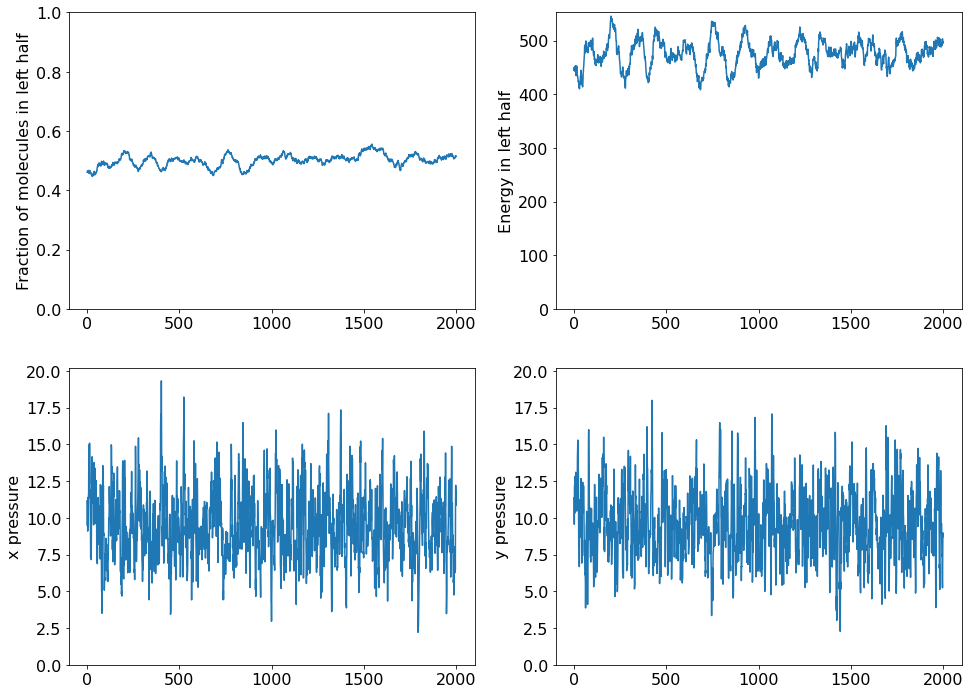

In [16]:
# we "smooth" the fluctuations in the pressure by averaging over N timesteps
def moving_window_average(data, N):
    padded_data= numpy.hstack([data[:N-1], data])
    return numpy.convolve(padded_data, numpy.ones(N)/N, mode='valid')

fig, axs = plt.subplots(2,2, figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(range(NFRAMES), frac_left)
plt.ylim(0,1)
plt.ylabel('Fraction of molecules in left half')
plt.subplot(2,2,2)
plt.plot(range(NFRAMES), energy_left)
plt.ylim(0)
plt.ylabel('Energy in left half')
ax0=plt.subplot(2,2,3, label='px')
plt.plot(range(NFRAMES), moving_window_average(numpy.array(impulse_x),5))
plt.ylabel('x pressure')
mx = plt.ylim()[1]
plt.subplot(2,2,4, label='py')
plt.plot(range(NFRAMES), moving_window_average(numpy.array(impulse_y),5))
plt.ylabel('y pressure')
mx = max(mx, plt.ylim()[1])
plt.ylim(0,mx)
ax0.set_ylim(0,mx)
plt.show()

For an equilibrium ergodic system like this, full of identical gas particles, we would expect that the distribution of speeds that each molecule has _over time_ should be the same as the distribution of speeds of all molecules *at a single time*:

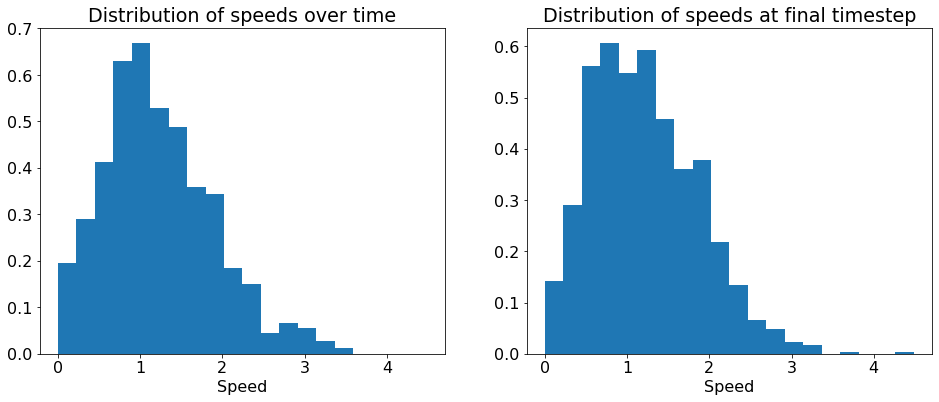

In [17]:
# Velocity magnitude distribution
# speed range?
mxv = max(numpy.max(numpy.linalg.norm(vel0, axis=1)), numpy.max(numpy.linalg.norm(velocities, axis=1)))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(numpy.linalg.norm(vel0, axis=1), range=(0,mxv), bins=20, density=True)
plt.title('Distribution of speeds over time')
plt.xlabel('Speed')
plt.subplot(1,2,2)
plt.hist(numpy.linalg.norm(velocities, axis=1), range=(0,mxv), bins=20, density=True)
plt.title('Distribution of speeds at final timestep')
plt.xlabel('Speed')
plt.show()

### Pressure in the ideal gas model

In this model the gas molecules are constantly bouncing off of the walls of the containing box. Since their momentum is changing in the collisions, a force is being exerted on them by the wall (and by Newton's third law, they are exerting a force on the walls of the box). We can actually work through this somewhat analytically.

We clearly need to consider an _average_ pressure, because we model the molecule-wall collisions as being instantaneous. So we will need to compute the "average force" in a time period. The way we will do this is to compute the _impulse_ caused by every collision. Remember that the impulse is force times time, which is also the change in momentum:

$$\int\vec{F}\ dt=\Delta\vec{p}$$
Let's upgrade to a 3 dimensional model, where there are vertical walls in the $xy$, $yz$, and $xz$ planes. Let's specifically look at walls in the $yz$ plane, located at $x=\pm L_x/2$. We'll analyze the wall at $x=+L/2$. When a molecule of mass $m$ hits the wall, its velocity $[v_x, v_y, v_z]$ is changed to $[-v_x, v_y, v_z]$ - the $x$-velocity is reversed. The momentum change of the molecule is $[-2mv_x, 0, 0]$, and therefore the impulse imparted to the wall is minus this: $[2mv_x, 0, 0]$. If there are $C$ such collisions in time $\Delta t$, the total impulse imparted will be $[2Cmv_x, 0, 0]$, and the average force will be the magnitude of the total impulse divided by $\Delta t$:

$$\overline{F} = \left[\frac{2Cm v_x}{\Delta t}, 0, 0 \right]$$
where the bar in $\overline{F}$ indicates an average. The _pressure_ is the magnitude of the average force over the area of the wall, let's call it $A_{yz}$ (which is presumably the product of the side lengths $L_y$ and $L_z$):

$$ P_\textrm{one molecule} = \frac{2Cm v_x}{A_{yz} \Delta t} $$
What is the number of collisions $C$? Let's consider it for a single molecule first, and let's imagine that it's not undergoing any collisions with other gas molecules during the time under consideration.  It needs to travel back and forth between $x=\pm L/2$. Because collisions with the other walls don't change the $x$-velocity, we can ignore the $y$ and $z$ components of the velocity. It will bounce back and forth between the two $yz$ walls with a horizontal velocity component $\pm v_x$. It will take time $2L_x / v_x$ for the same molecule to cross the length of the box and to come back to collide on the original wall again. So the number of collisions $C$ in the time $\Delta t$ is 

$$ C = \frac{\Delta t}{2 L_x / v_x} = \frac{v_x \Delta t}{2 L_x}$$
Putting this into the earlier equation:

$$ P_\textrm{one molecule} = \frac{2 m v_x}{A_{yz} \Delta t}\frac{v_x \Delta t}{2 L_x} = \frac{m}{L_x A_{yz}}{v_x^2} = \frac{m}{V}v_x^2$$
where the volume $V$ is $L_x A_{yz}$.

The result above is for a single molecule. Of course there are many molecules, and they don't all have the same velocity. Adding together the pressure from all molecules, we would have

$$ P = \sum_\textrm{molecules} P_\textrm{one molecule} = \frac{N m}{V}\overline{v_x^2} $$

where $\overline{v_x^2}$ is the average value of $v_x^2$ over all molecules. (It's the average of $v_x^2$, not the square of the average of $v_x$, to be clear.) The average kinetic energy per molecule is $\overline{E} = \frac{1}{2} m \overline{v^2} = \frac{1}{2} m (\overline{v_x^2} + \overline{v_y^2} + \overline{v_z^2})$ (the average of the sum is the sum of the averages). With a random distribution of velocities, one expects $\overline{v_x^2} = \overline{v_y^2} = \overline{v_z^2}$, so

$$ m \overline{v_x^2} = \frac{1}{3}\left[m (\overline{v_x^2} + \overline{v_y^2} + \overline{v_z^2})\right] = \frac{2}{3}\left(\frac{1}{2} m \overline{v^2}\right) = \frac{2}{3}\overline{E} $$
So, finally,

$$ P = \frac{N}{V}\left[\frac{2}{3}\overline{E}\right] $$
or

$$ PV = N\left[\frac{2}{3}\overline{E}\right]$$

If we compare this to the standard form of the ideal gas law above ($PV = nRT$), we would conclude

$$ nRT = N\left[\frac{2}{3}\overline{E}\right] $$

where $n$ is the number of _moles_ of molecules and $N$ is the _absolute number_ of molecules, so $N = n N_A$ where $N_A$ is Avogadro's Number. Therefore

$$
\begin{align*}
RT &= N_A \left[\frac{2}{3}\overline{E}\right]\\
\frac{R}{N_A} T &= k_B T = \frac{2}{3}\overline{E}\\
\overline{E} &= \frac{3}{2} k_B T
\end{align*}
$$

We have defined the constant $k_B = R/N_A = 1.38 \times 10^{-23}$ J &middot; K<sup>-1</sup>; it is called _Boltzmann's constant_ and is more fundamental than $R$ (which, in the kinetic theory of gases, is just equal to $k_B N_A$). Boltzmann's constant is a conversion factor between temperature and energy, and tells us how the temperature relates to the average kinetic energy of the molecules.  We have the first indication that the thing we call _temperature_ is just a way of measuring the average energy carried by the molecules that comprise a system. It may be very difficult to observe this energy from the outside, or to extract it in a useful way, but it's there.

Note that:
* the average kinetic energy $\frac{3}{2} k_B T$ for a molecule of an ideal gas is independent of the type of molecule it is: it doesn't depend on the mass or any other properties of the particle. 
* The temperature $T$ needs to be expressed in an "absolute" scale for this to make sense. At absolute zero ($T=0$), the molecules will have completely stopped.
* at 273 K (0&deg;C) the kinetic energy of a molecule is $5.7 \times 10^{-21}$ J. For nitrogen (whose molecules have a mass $4.65 \times 10^{-26}$ kg) the average molecular speed &mdash; where here we mean the root-mean-square value $v_\mathrm{rms} \equiv \sqrt{\overline{v^2}}$ &mdash; is $\approx 500$ m/s.

If we were to repeat the exercise with a two-dimensional system, we would find that $\overline{E} = k_B T = \frac{2}{2} k_B T$ instead of $\frac{3}{2} k_B T$. The factor "3" comes from the fact that there are three dimensions the molecules can move in. We will come back to this later in the form of the *equipartition principle*, which states that *particles will on average have $\frac{1}{2} k_B T$ of energy per degree of freedom*. Here the "degree of freedom" is each perpendicular direction the molecules can move in, so there are three.


In [ ]:
# visualization of the path of the first particle
fig = plt.figure(figsize=(8,8))
line, = plt.plot([],[], 'r')
fig.axes[0].set_aspect('equal')
plt.xlim(-SIZE[0]/2,SIZE[0]/2)
plt.ylim(-SIZE[1]/2,SIZE[1]/2)
def animate(i):
    line.set_data(pos0[:i,0], pos0[:i,1])
    return [line]

anim = animation.FuncAnimation(fig, animate,
                               frames=500,
                               repeat=False)
plt.close()
HTML(anim.to_jshtml(fps=20))

In [ ]:
# visualization of the motion of all particles
fig,ax = plt.subplots(figsize=(8,8))
circles = [plt.Circle(posall[0][j], radii[j], color='b' if j == 0 else 'r') for j in range(NPARTICLES)]
for circle in circles:
    ax.add_artist(circle)
ax.set_aspect('equal')
plt.xlim(-SIZE[0]/2,SIZE[0]/2)
plt.ylim(-SIZE[1]/2,SIZE[1]/2)

def animate(i):
    for j in range(NPARTICLES):
        circles[j].set_center(posall[i][j])
    return circles

anim = animation.FuncAnimation(fig, animate,
                               frames=300,
                              repeat=False,
                              blit=True,
                              cache_frame_data=False)
plt.close()
HTML(anim.to_jshtml(fps=20))

### Maxwell-Boltzmann velocity distribution

We saw above the distribution of molecular velocities (in a 2D model); in equilibrium we should expect that the average distribution does not change with time. From general mathematical principles Maxwell was able to demonstrate that the distribution of each component of velocity should be a normal distribution centered at zero:

$$ P(v_x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-v_x^2/2\sigma^2) $$

Since $\sigma^2$, the standard deviation, is the average value of $v_x^2$ (since $\overline{v_x} = 0$), and from the equipartition principle we expect 

$$\frac{1}{2} m \overline{v_x^2}= \frac{1}{2} m \sigma^2 = \frac{1}{2} k_B T,$$

we find $\sigma = \sqrt{k_B T/m}$, we get

$$ P(v_x) = \sqrt{\frac{m}{2\pi k_B T}}\exp(-mv_x^2/2 k_B T).  $$

The probability distribution for the vector $[v_x, v_y, v_z]$ is the product $P(v_x) P(v_y) P(v_z)$, where the function $P$ is the same for all three directions (the system is spherically symmetric, there is no preferred direction). The probability distribution for the absolute *speed* can be shown to be

$$ P_{3D}(v) = \left(\frac{m}{2\pi k_B T}\right)^{3/2} 4\pi v^2 \exp(-mv^2/2 k_B T). $$

Let's compare our observed velocity distribution with the predicted Maxwell-Boltzmann form. We generated velocities with $\sigma = \sqrt{\tilde T}$, where $\tilde T$ is the `TEMPSCALE` variable in the code. This means that $\tilde T = k_B T/m$, and we made a 2D simulation (instead of 3D), so we will have a slightly different distribution:

$$P_{2D}(v) = \left(\frac{1}{2\pi \tilde T}\right) 2\pi v \exp(-v^2/2 \tilde T) $$

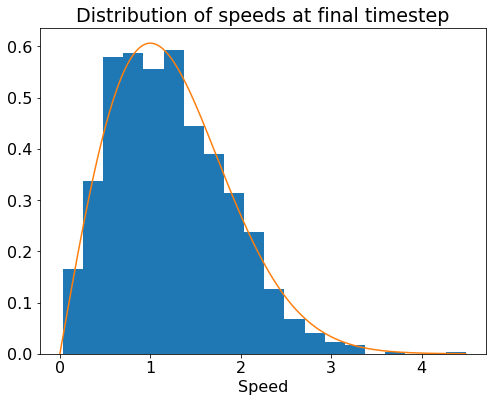

In [20]:
# special case of M-B distribution corresponding to how we've parametrized things in a 2D simulation
def maxwell_boltzmann_2d(v, Ttilde):
    return (v/Ttilde)*numpy.exp(-numpy.square(v)/(2*Ttilde))

_, bins, _ = plt.hist(numpy.linalg.norm(velocities, axis=1), bins=20, density=True)
plt.plot(numpy.linspace(0,bins[-1],200), maxwell_boltzmann_2d(numpy.linspace(0,bins[-1],200), TEMPSCALE))
plt.title('Distribution of speeds at final timestep')
plt.xlabel('Speed')
plt.show()